In [46]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
df=pd.read_csv("/content/tweet_emotions.csv")
df

,Sentiment,Tweet
0,neutral,"@united 877 from amsterdam to ewr, 02.27.2015,..."
1,negative,@united IT-problems with the link? #3thparty
2,positive,@united -today the staff @ MSP took customer s...
3,negative,@AmericanAir but have been yet to receive assi...
4,negative,@SouthwestAir you won't let me change my rese...
...,...,...
11675,negative,@AmericanAir That what I hoped - contacted the...
11676,negative,@SouthwestAir 20 minutes on hold waiting is ri...
11677,neutral,@virginamerica may start service to Hawaii fro...
11678,negative,@AmericanAir She could even see that I had tri...


Take care of all the preprocessing stuff in the 'Tweet' column.

In [48]:
def preprocess(text):
    text = text.lower() # convert to lowercase

    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove usernames

    text = re.sub(r'[^\w\s]', '', text) # remove punctuation and special characters

    tokens = word_tokenize(text) # tokenization (seperate each tweet to multiple words)

    stop_words = set(stopwords.words('english'))
    words = [word for word in tokens if word not in stop_words] # remove the stopwords

    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words] # stemming (words are reduced to their root forms like 'running' --> 'run')

    processed_text = ' '.join(stemmed_words) # join the words back into a sentence
    return processed_text

# create a new colum after preprocessing the 'Tweet' column
df['Tweet'] = df['Tweet'].apply(preprocess)
df

,Sentiment,Tweet
0,neutral,877 amsterdam ewr 02272015 737300
1,negative,itproblem link 3thparti
2,positive,today staff msp took custom servic new level f...
3,negative,yet receiv assist one agent secur new connect ...
4,negative,wont let chang reserv onlin im wast time httpt...
...,...,...
11675,negative,hope contact 3 wk ago respond still issu us fu...
11676,negative,20 minut hold wait ridicul
11677,neutral,may start servic hawaii sanfrancisco year http...
11678,negative,could even see tri make transact wouldnt offer...


vectorize the processed_tweet column using TF-IDF vectorization


In [49]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Tweet'])
X

<11680x11326 sparse matrix of type '<class 'numpy.float64'>'
	with 104355 stored elements in Compressed Sparse Row format>

In [50]:
feature_names = vectorizer.get_feature_names_out()
print(feature_names)

['0011' '0016' '006' ... 'zuke' 'zurich' 'zurichnew']


1-Neutral tweets :  2461
2-Negative tweets :  7331
3-Positive tweets :  1888


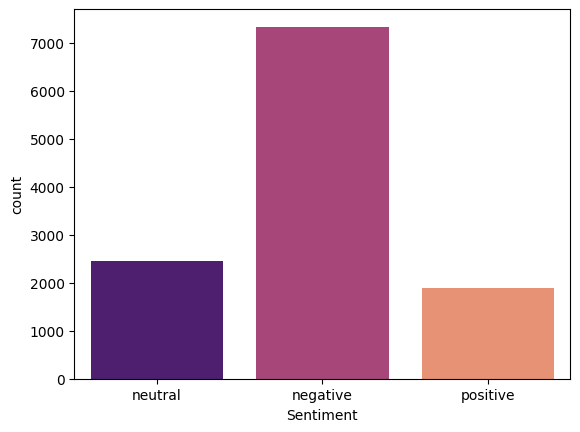

In [51]:
y=df.Sentiment
ax = sns.countplot(x=y,palette='magma')
negative,neutral,positive=y.value_counts()
print("1-Neutral tweets : ",neutral)
print("2-Negative tweets : ",negative)
print("3-Positive tweets : ",positive)

replace the string values of the column 'Sentiment' to numeric values, and fills any NaN values that might have been generated after the .map with  the original values from the 'Sentiment' column


In [52]:
(df.Sentiment).unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [53]:
replace = {'neutral': 0, 'negative': -1, 'positive': 1}
df['Sentiment'] = df['Sentiment'].map(replace).fillna(df['Sentiment'])
df

,Sentiment,Tweet
0,0,877 amsterdam ewr 02272015 737300
1,-1,itproblem link 3thparti
2,1,today staff msp took custom servic new level f...
3,-1,yet receiv assist one agent secur new connect ...
4,-1,wont let chang reserv onlin im wast time httpt...
...,...,...
11675,-1,hope contact 3 wk ago respond still issu us fu...
11676,-1,20 minut hold wait ridicul
11677,0,may start servic hawaii sanfrancisco year http...
11678,-1,could even see tri make transact wouldnt offer...


Split the data to 80% training and 20% testing

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X.shape, X_train.shape, X_test.shape)

(11680, 11326) (9344, 11326) (2336, 11326)


Train the model, test it by predecting on the test data, then calculate and visualize the results

In [55]:
acc_list = []
rec_list = []
prec_list = []
f1_list = []

In [56]:
for k in [3,5,7,10,13]:

  classifier = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
  classifier.fit(X_train, y_train) # train the model

  predicted_label = classifier.predict(X_test) # test it

  cmatrix = confusion_matrix(y_test, predicted_label) # draw the confusion matrix

  creport = classification_report(y_test, predicted_label) # draw the classification report

  accuracy_score = (metrics.accuracy_score(y_test,predicted_label)) # calculate the accuracy
  accuracy_score = (round(accuracy_score,2))*100
  acc_list.append(accuracy_score)


  macro_precision = (metrics.precision_score(y_test, predicted_label, average='macro')) # calculate the precision which is the ratio of true positive predictions to the total number of predicted positive instances
  macro_precision = (round(macro_precision,2))*100
  prec_list.append(macro_precision)

  macro_recall = (metrics.recall_score(y_test, predicted_label, average='macro')) # calculate the recall which is the ratio of true positive predictions to the total number of actual positive instances
  macro_recall = (round(macro_recall,2))*100
  rec_list.append(macro_recall)

  macro_f1 = (metrics.f1_score(y_test, predicted_label, average='macro')) # calculate the f1-score which is  harmonic mean of precision and recall, it provides a balanced measure that considers both false positives and false negatives
  macro_f1 = (round(macro_f1,2))*100
  f1_list.append(macro_f1)

  # Support is the number of actual occurrences of the class in the specified dataset

  print(f"\nConfusion Matrix for k = {k} is:\n")
  print(cmatrix)
  print(f"\nClassification Report for k = {k} is:\n")
  print(creport)
  print("Accuracy Score for k = {0} is: {1}%".format(k,accuracy_score))
  print("Macroaveraged Recall for k = {0} is: {1}%".format(k,macro_recall))
  print("Macroaveraged Precision for k = {0} is: {1}%".format(k,macro_precision))
  print("Macroaveraged F1-score for k = {0} is: {1}%".format(k,macro_f1))


Confusion Matrix for k = 3 is:

[[  45 1420    7]
 [   8  477   12]
 [   8  287   72]]

Classification Report for k = 3 is:

              precision    recall  f1-score   support

    negative       0.74      0.03      0.06      1472
     neutral       0.22      0.96      0.36       497
    positive       0.79      0.20      0.31       367

    accuracy                           0.25      2336
   macro avg       0.58      0.40      0.24      2336
weighted avg       0.64      0.25      0.16      2336

Accuracy Score for k = 3 is: 25.0%
Macroaveraged Recall for k = 3 is: 40.0%
Macroaveraged Precision for k = 3 is: 57.99999999999999%
Macroaveraged F1-score for k = 3 is: 24.0%

Confusion Matrix for k = 5 is:

[[  29 1439    4]
 [   7  483    7]
 [   5  304   58]]

Classification Report for k = 5 is:

              precision    recall  f1-score   support

    negative       0.71      0.02      0.04      1472
     neutral       0.22      0.97      0.35       497
    positive       0.84     

<function matplotlib.pyplot.show(close=None, block=None)>

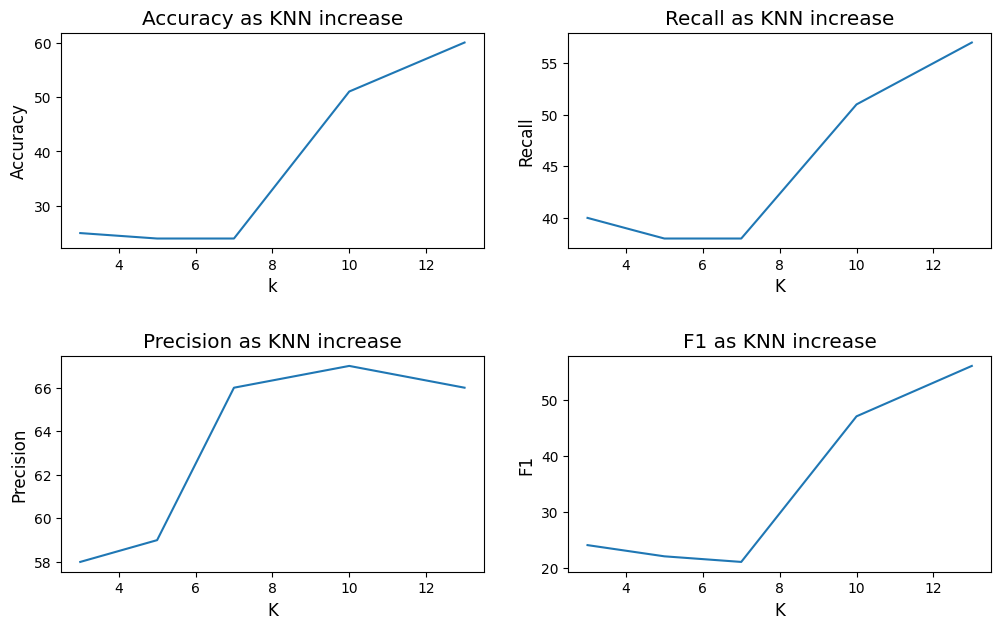

In [57]:
k_ls =[3,5,7,10,13]

fig = plt.figure(figsize=(12,7))

plt.subplot(2,2,1)
plt.plot(k_ls,acc_list)
plt.title("Accuracy as KNN increase",fontsize='x-large')
plt.xlabel("k",fontsize='large')
plt.ylabel("Accuracy",fontsize='large')

plt.subplot(2,2,2)
plt.plot(k_ls,rec_list)
plt.title("Recall as KNN increase",fontsize='x-large')
plt.xlabel("K",fontsize='large')
plt.ylabel("Recall",fontsize='large')

plt.subplot(2,2,3)
plt.plot(k_ls,prec_list)
plt.title("Precision as KNN increase",fontsize='x-large')
plt.xlabel("K",fontsize='large')
plt.ylabel("Precision",fontsize='large')

plt.subplot(2,2,4)
plt.plot(k_ls,f1_list)
plt.title("F1 as KNN increase",fontsize='x-large')
plt.xlabel("K",fontsize='large')
plt.ylabel("F1",fontsize='large')

fig.subplots_adjust(hspace=.5)

plt.show